
Practical 1<br>
Greatly inspired by Stanford CS224 2019 class.<br>


In [1]:
import sys
import pprint
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import random
import nltk
from collections import Counter
import random
import numpy as np
import scipy as sp
from nltk.corpus import reuters
from nltk.corpus.reader import pl196x
from sklearn.decomposition import PCA, TruncatedSVD

In [4]:
nltk.download('reuters')
nltk.download('pl196x')

[nltk_data] Downloading package reuters to /home/tom/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package pl196x to /home/tom/nltk_data...
[nltk_data]   Package pl196x is already up-to-date!


In [6]:
START_TOKEN = '<START>'
END_TOKEN = '<END>'
np.random.seed(0)
random.seed(0)

Part 1.a) -- distinct words implementation

In [9]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the 
            corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the 
            corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    for doc in corpus:
        for word in doc:
            if word not in corpus_words: corpus_words.append(word)
    corpus_words = sorted(corpus_words)
    num_corpus_words = len(corpus_words)
    # ------------------
    return corpus_words, num_corpus_words

Define toy corpus

In [10]:
test_corpus = ["START Ala miec kot i pies END".split(" "),
               "START Ala lubic kot END".split(" ")]     
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

Correct answers

In [11]:
ans_test_corpus_words = sorted(list(set([
    'Ala', 'END', 'START', 'i', 'kot', 'lubic', 'miec', 'pies'])))
ans_num_corpus_words = len(ans_test_corpus_words)

Test correct number of words

In [12]:
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

Test correct words

In [13]:
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

Part 1.b) -- Co-occurence matrix implementation

In [16]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window.
            Words near edges will have a smaller number of co-occurring words.
              
              For example, if we take the document "START All that glitters is not gold END" with window size of 4,
              "All" will co-occur with "START", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (numpy matrix of shape (number of corpus words, number of corpus words)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the 
                same as the ordering of the words given by the distinct_words 
                function.
            word2Ind (dict): dictionary that maps word to index 
                (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2Ind = {}

    # ------------------
    # Write your implementation here.
    for i, w in enumerate(words):
        word2Ind[w] = i
    
    M = np.zeros((num_words, num_words))
       
    for doc in corpus:
        # print(doc)
        context = Counter()
        for i in range(min(len(doc), window_size+1)):
            context[doc[i]] += 1
        
        for index, focus in enumerate(doc):
            context[focus] -= 1
            # print(f'{index}, {focus}: {context}')
            for w in context:
                if context[w] != 0:
                    M[word2Ind[focus]][word2Ind[w]] += 1
            context[focus] += 1
            if index-window_size >= 0:
                context[doc[index-window_size]] -= 1
            if index+window_size+1 < len(doc):
                context[doc[index+window_size+1]] += 1

    # All focuses count themselves twice if they are in their window.
    # To counter that, we're halving all values on the diagonal of M.
    for i in range(M.shape[0]):
        M[i][i] /= 2
    # ------------------
    return M, word2Ind

Define toy corpus and get student's co-occurrence matrix

In [17]:
test_corpus = ["START Ala miec kot i pies END".split(" "),
               "START Ala lubic kot END".split(" ")]     
M_test, word2Ind_test = compute_co_occurrence_matrix(
    test_corpus, window_size=1)

Correct M and word2Ind

In [18]:
M_test_ans = np.array([
    [0., 0., 2., 0., 0., 1., 1., 0.],
    [0., 0., 0., 0., 1., 0., 0., 1.],
    [2., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 1., 0., 0., 1.],
    [0., 1., 0., 1., 0., 1., 1., 0.],
    [1., 0., 0., 0., 1., 0., 0., 0.],
    [1., 0., 0., 0., 1., 0., 0., 0.],
    [0., 1., 0., 1., 0., 0., 0., 0.]
])
word2Ind_ans = {
    'Ala': 0, 'END': 1, 'START': 2, 'i': 3, 'kot': 4, 'lubic': 5, 'miec': 6,
    'pies': 7}

Test correct word2Ind

In [20]:
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

Test correct M shape

In [21]:
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

Test correct M values

In [22]:
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

Part 1.c) -- Reduction to k dimension implementation

In [25]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality
        (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following
         SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
        Params:
            M (numpy matrix of shape (number of corpus words, number 
                of corpus words)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)):
            matrix of k-dimensioal word embeddings.
            In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))

    # ------------------
    # Write your implementation here.
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    # ------------------
    print("Done.")
    return M_reduced

Define toy corpus and run student code

In [26]:
test_corpus = ["START Ala miec kot i pies END".split(" "),
               "START Ala lubic kot END".split(" ")]  
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

Running Truncated SVD over 8 words...
Done.


Test proper dimensions

In [27]:
assert (M_test_reduced.shape[0] == 8), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 8)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

Part 1.d) -- Plot embeddings implementation

In [30]:
def plot_embeddings(M_reduced, word2Ind, words, plot_name):
    """ Plot in a scatterplot the embeddings of the words specified 
        in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the
            corpus , k)): matrix of k-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to
            visualize
    """

    # ------------------
    # Write your implementation here.
    indicies = []
    for w in words:
        indicies.append(word2Ind[w])
    plt.scatter(M_reduced[indicies, 0], M_reduced[indicies, 1])
    for i, w in enumerate(words):
        plt.annotate(w, (M_reduced[indicies[i], 0], M_reduced[indicies[i], 1]))
    plt.savefig(plot_name+'.png')
    plt.show()
    # ------------------#

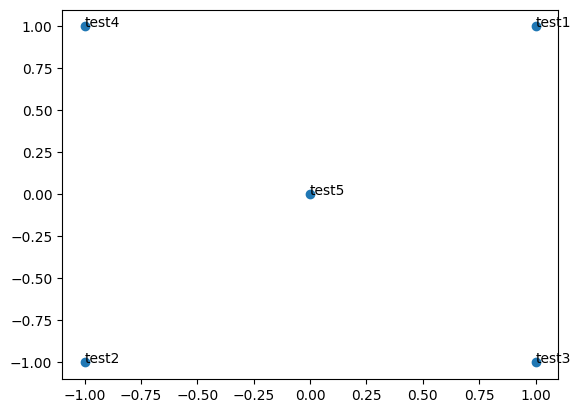

In [32]:
M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {
    'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words, 'plot_1d')

Part 1.e) -- Co-occurence plot analysis

In [35]:
def read_corpus_pl():
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    pl196x_dir = nltk.data.find('corpora/pl196x')
    pl = pl196x.Pl196xCorpusReader(
        pl196x_dir, r'.*\.xml', textids='textids.txt',cat_file="cats.txt")
    tsents = pl.tagged_sents(fileids=pl.fileids(),categories='cats.txt')[:5000]
    return [[START_TOKEN] + [
        w[0].lower() for w in list(sent)] + [END_TOKEN] for sent in tsents]

In [36]:
def plot_unnormalized(corpus, words):
    M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(
        corpus)
    M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
    plot_embeddings(M_reduced_co_occurrence, word2Ind_co_occurrence, words, 'plot_1e_1')

In [37]:
def plot_normalized(corpus, words):
    M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(
        corpus)
    M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)
    # Rescale (normalize) the rows to make them each of unit-length
    M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
    M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting
    plot_embeddings(M_normalized, word2Ind_co_occurrence, words, 'plot_1e_2')

In [38]:
pl_corpus = read_corpus_pl()
words = [
    "sztuka", "śpiewaczka", "literatura", "poeta", "obywatel"]

Running Truncated SVD over 22957 words...
Done.


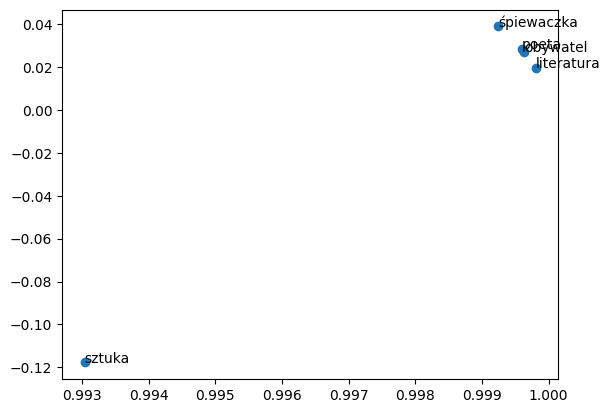

Running Truncated SVD over 22957 words...
Done.


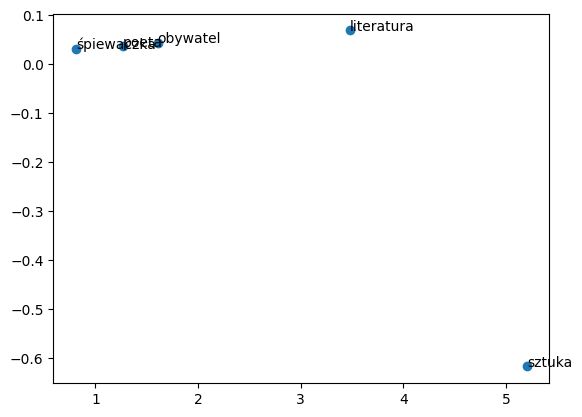

In [39]:
plot_normalized(pl_corpus, words)
plot_unnormalized(pl_corpus, words)

Section 2
---

In [47]:
wv_from_bin_pl = KeyedVectors.load("word2vec_100_3_polish.bin")

Part 2.a)

In [48]:
def get_matrix_of_vectors(wv_from_bin, required_words):
    """ Put the word2vec vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 3 million word2vec vectors
                         loaded from file
        Return:
            M: numpy matrix shape (num words, 300) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    words = list(wv_from_bin.key_to_index.keys())
    print("Shuffling words ...")
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [49]:
M, word2Ind = get_matrix_of_vectors(wv_from_bin_pl, words)
M_reduced = reduce_to_k_dim(M, k=2)

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10006 words...
Done.


/tmp/ipykernel_24595/3020917691.py:20: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))
/tmp/ipykernel_24595/3020917691.py:27: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))


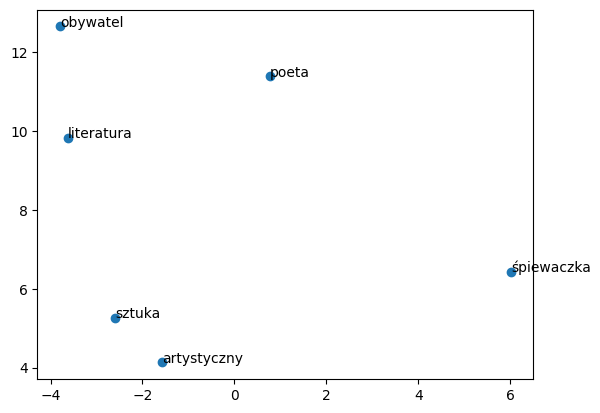

In [51]:
words = [
    "sztuka", "śpiewaczka", "literatura", "poeta", "artystyczny", "obywatel"]
plot_embeddings(M_reduced, word2Ind, words, 'plot_2a')

Part 2.b) -- Polysemous words

In [67]:
wv_from_bin_pl.most_similar("stówa") # Polysemous: 'cent' and 'wers'
wv_from_bin_pl.most_similar("pokój") # Isn't polysemous
wv_from_bin_pl.most_similar("zamek") # Isn't polysemous
wv_from_bin_pl.most_similar("maska") # Isn't polysemous
wv_from_bin_pl.most_similar("myszka") # Isn't polysemous
wv_from_bin_pl.most_similar("pióro") # Isn't polysemous
wv_from_bin_pl.most_similar("język") # Isn't polysemous
wv_from_bin_pl.most_similar("kolejka") # Isn't polysemous
wv_from_bin_pl.most_similar("żuraw") # Isn't polysemous
wv_from_bin_pl.most_similar("zebra") # Isn't polysemous
wv_from_bin_pl.most_similar("guzik") # Polysemous: 'przycisk' and 'pasek'
# ------------------

[('guziczek', 0.8716678619384766),
 ('przycisk', 0.7479563355445862),
 ('klamerka', 0.7304871678352356),
 ('pasek', 0.7294151186943054),
 ('klips', 0.7229782938957214),
 ('suwak', 0.7220331430435181),
 ('klawisz', 0.7217313051223755),
 ('mankiet', 0.7134830355644226),
 ('agrafka', 0.7102128267288208),
 ('paska', 0.7100707292556763)]

Part 2.c) -- Synonyms and Antonyms

In [68]:
w1 = "radosny"
w2 = "pogodny"
w3 = "smutny"
w1_w2_dist = wv_from_bin_pl.distance(w1, w2)
w1_w3_dist = wv_from_bin_pl.distance(w1, w3)
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

Synonyms radosny, pogodny have cosine distance: 0.3306429386138916
Antonyms radosny, smutny have cosine distance: 0.347899854183197


In [75]:
w1 = "czysty"
w2 = "szlachetny"
w3 = "brudny"
w1_w2_dist = wv_from_bin_pl.distance(w1, w2)
w1_w3_dist = wv_from_bin_pl.distance(w1, w3)
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

Synonyms czysty, szlachetny have cosine distance: 0.4478588104248047
Antonyms czysty, brudny have cosine distance: 0.6309119760990143


Part 2.d) -- Finding analogies

In [102]:
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=["dworzec", "samolot"], negative=["pociąg"]))

[('lotnisko', 0.7290045619010925),
 ('lądowisko', 0.7173386216163635),
 ('hangar', 0.697532057762146),
 ('śmigłowiec', 0.6749110817909241),
 ('sterowiec', 0.6597589254379272),
 ('kosmodrom', 0.659102201461792),
 ('superforteca', 0.646694004535675),
 ('transportowiec', 0.6378589868545532),
 ('bombowiec', 0.6376054883003235),
 ('odrzutowiec', 0.6329388618469238)]


Part 2.e) -- Incorrect analogies

In [106]:
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=["dom", "pies"], negative=["człowiek"]))

[('kurnik', 0.7462329268455505),
 ('stajnia', 0.739808976650238),
 ('zagroda', 0.7183098793029785),
 ('chat', 0.7029213905334473),
 ('stodoła', 0.7014257311820984),
 ('domek', 0.6837722063064575),
 ('obora', 0.6771073341369629),
 ('gołębnik', 0.6766341924667358),
 ('podwórko', 0.6738435626029968),
 ('buda', 0.6647446751594543)]


Part 2.f) -- Guided Analysis of Bias in Word Vectors

In [107]:
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=['kobieta', 'szef'], negative=['mezczyzna']))
print()
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=['mezczyzna', 'prezes'], negative=['kobieta']))

[('własika', 0.5678122639656067),
 ('agent', 0.5483713150024414),
 ('oficer', 0.5411549210548401),
 ('esperów', 0.5383270978927612),
 ('interpol', 0.5367037653923035),
 ('antyterrorystyczny', 0.5327680110931396),
 ('komisarz', 0.5326411128044128),
 ('europolu', 0.5274547338485718),
 ('bnd', 0.5271410346031189),
 ('pracownik', 0.5215375423431396)]

[('wiceprezes', 0.6396454572677612),
 ('czlonkiem', 0.5929950475692749),
 ('przewodniczący', 0.5746127963066101),
 ('czlonek', 0.5648552179336548),
 ('przewodniczacym', 0.5586849451065063),
 ('wiceprzewodniczący', 0.5560489892959595),
 ('obowiazków', 0.5549101233482361),
 ('obowiazani', 0.5544129610061646),
 ('dyrektor', 0.5513691306114197),
 ('obowiazany', 0.5471130609512329)]


Part 2.g) -- Independent Analysis of Bias in Word Vectors

In [143]:
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=['kobieta', 'garaż'], negative=['mezczyzna']))

[('pralnia', 0.5876626372337341),
 ('łazienka', 0.5784067511558533),
 ('kwiaciarnia', 0.5732817649841309),
 ('furgonetka', 0.5589639544487),
 ('sklep', 0.5565803647041321),
 ('sklepik', 0.5560817122459412),
 ('ubikacja', 0.5506219267845154),
 ('supermarket', 0.5498917698860168),
 ('drogeria', 0.548071563243866),
 ('herbaciarnia', 0.5451033115386963)]


/home/tom/Python/venv3.10/lib64/python3.10/site-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


Section 3 -- English
---

In [117]:
wv_from_bin_eng = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

Part 3.b) -- Polysemous words in English:

In [126]:
wv_from_bin_eng.most_similar("free") # Polysemy: 'restricted' and 'nominal fee'
# ------------------

[('Free', 0.6718050241470337),
 ('Six_Flags_website_http://www.sixflags.com', 0.5262574553489685),
 ('FREE', 0.5083318948745728),
 ('nominal_fee', 0.45694464445114136),
 ('therapy_systems_NFITS', 0.4531921148300171),
 ('restricted', 0.4485984146595001),
 ('complimentary', 0.4475708603858948),
 ('afree', 0.4412049949169159),
 ('www.dickmorris.com', 0.4327717125415802),
 ('###-####_artmuseumgr.org', 0.4296324551105499)]

Part 3.c) -- Antonym that's further than a synonym in English:

In [133]:
w1 = "smart"
w2 = "wise"
w3 = "dull"
w1_w2_dist = wv_from_bin_eng.distance(w1, w2)
w1_w3_dist = wv_from_bin_eng.distance(w1, w3)
print("Synonyms {}, {} have cosine distance: {}".format(w1, w2, w1_w2_dist))
print("Antonyms {}, {} have cosine distance: {}".format(w1, w3, w1_w3_dist))

Synonyms smart, wise have cosine distance: 0.5292271971702576
Antonyms smart, dull have cosine distance: 0.8111068904399872


Part 3.d) -- Finding analogy in English:

In [140]:
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=["airport", "ship"], negative=["plane"]))

[('docks', 0.7099661827087402),
 ('freeport', 0.6699029803276062),
 ('lanseria', 0.6656195521354675),
 ('felixstowe', 0.6609316468238831),
 ('shipping', 0.6513776779174805),
 ('gourock', 0.6508407592773438),
 ('parkeston', 0.6472496390342712),
 ('port', 0.6461513638496399),
 ('cunarda', 0.6365473866462708),
 ('howrah', 0.6359425187110901)]


Part 3.e) -- Incorrect analogy in English:

In [141]:
pprint.pprint(wv_from_bin_pl.most_similar(
    positive=["apartment", "dog"], negative=["human"]))

[('chinatown', 0.6753914952278137),
 ('restaurant', 0.6662924885749817),
 ('saloon', 0.6486155986785889),
 ('ritz', 0.647412896156311),
 ('savoy', 0.6424195170402527),
 ('mansion', 0.6414093971252441),
 ('choirgirl', 0.6361886262893677),
 ('coffee', 0.6361327767372131),
 ("shepheard's", 0.6305875778198242),
 ('biltimore', 0.629713237285614)]


Part 3.f) -- Guided analysis of bias in word vectors in English:

In [142]:
pprint.pprint(wv_from_bin_eng.most_similar(
    positive=['woman', 'boss'], negative=['man']))
print()
pprint.pprint(wv_from_bin_eng.most_similar(
    positive=['man', 'CEO'], negative=['woman']))

[('bosses', 0.5522644519805908),
 ('manageress', 0.49151360988616943),
 ('exec', 0.45940810441970825),
 ('Manageress', 0.4559843838214874),
 ('receptionist', 0.4474116563796997),
 ('Jane_Danson', 0.44480547308921814),
 ('Fiz_Jennie_McAlpine', 0.4427576959133148),
 ('Coronation_Street_actress', 0.44275563955307007),
 ('supremo', 0.4409853219985962),
 ('coworker', 0.43986251950263977)]

[('COO', 0.7348989248275757),
 ('Chief_Executive_Officer', 0.7298896908760071),
 ('chief_executive', 0.726062536239624),
 ('Chief_Operating_Officer', 0.711536705493927),
 ('Chief_Executive', 0.6770262718200684),
 ('ceo', 0.6465960741043091),
 ('Chairman', 0.6462056040763855),
 ('CTO', 0.6153501868247986),
 ('CEOof', 0.6049222946166992),
 ('Managing_Director', 0.6035969257354736)]
